In [1]:
import json
import re

import pandas as pd
import numpy as np

from datetime import datetime
from typing import Dict, List
from tqdm import tqdm

# Embedding algorithm essentials
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


In [2]:
df_db_tracks = pd.read_csv('../dataset/tracks.csv')
df_db_tracks['id_artists'] = df_db_tracks['id_artists'].apply(lambda x: x[1:-1].strip().replace("'", "").split(','))
df_db_tracks.head(2)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,0,-13.338,1,0.451,0.674,0.744,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.263,0,-22.136,1,0.957,0.797,0.000,0.148,0.655,102.009,1


In [3]:
df_db_artists = pd.read_csv('../dataset/artists.csv')
df_db_artists['genres'] = df_db_artists['genres'].apply(lambda x: x[1:-1].strip().replace("'", "").split(','))
df_db_artists.tail(2)

,id,followers,genres,name,popularity
1162093,5nvjpU3Y7L6Hpe54QuvDjy,2357.0,[black comedy],Donnell Rawlings,15
1162094,2bP2cNhNBdKXHC6AnqgyVp,40.0,[new comedy],Gabe Kea,8


In [4]:
artist_information = df_db_artists.set_index('id').to_dict(orient='index')

In [5]:
def get_genres_for_artists(id_artists: List[str]) -> List[str]:
    genres = []
    for artist_id in id_artists:
        genres += artist_information[artist_id]['genres'] if artist_id in artist_information.keys() else []
    return list(set(genres))


def get_popularity_for_artists(id_artists: List[str]) -> List[int]:
    popularity = []
    for artist_id in id_artists:
        popularity += [artist_information[artist_id]['popularity']] if artist_id in artist_information.keys() else []
    return popularity

In [6]:
df_db_tracks['genres'] = df_db_tracks['id_artists'].apply(lambda x: get_genres_for_artists(x))
df_db_tracks.head(1)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,...,-13.338,1,0.451,0.674,0.744,0.151,0.127,104.851,3,[]


#### Artist Representation

Create the artist social network, concatenated artist ids, for which we will create embeddings with w2v

1. Collaboration relationship
2. References relationship
3. Concert relationship
4. Co-existence in playlists relationship

In [7]:
# collaborations
df_db_tracks_artists = df_db_tracks[['id', 'id_artists']]
collaborations = df_db_tracks_artists.to_dict('records')
collaborations = [[a.strip() for a in track['id_artists']] for track in collaborations]

In [8]:
import json

with open('../dataset/artists_wiki_graph.json') as json_file:
    references = json.load(json_file)


with open('../dataset/concerts_artists_graph.json') as json_file:
    concerts = json.load(json_file)

In [18]:
graph = {}

concert_weight = 2
collaboration_weight = 4
reference_weight = 1
playlist_coexistence = 3

for track_artists_id in tqdm(collaborations):
    # O(n^2) complexity for artists
    for artist_root in track_artists_id:
        for artist_edge in track_artists_id:
            if artist_root == artist_edge: continue
            
            if artist_root not in graph:
                graph[artist_root] = {}
            
            if artist_edge not in graph[artist_root]:
                graph[artist_root][artist_edge] = 0
            
            graph[artist_root][artist_edge] += collaboration_weight


for page_references in tqdm(references):
    # O(n^2) complexity for artists
    for artist_root in page_references['artists']:
        for artist_edge in page_references['artists']:
            if artist_root == artist_edge: continue
            
            if artist_root not in graph:
                graph[artist_root] = {}
            
            if artist_edge not in graph[artist_root]:
                graph[artist_root][artist_edge] = 0
            
            graph[artist_root][artist_edge] += reference_weight



for page_references in tqdm(concerts):
    # O(n^2) complexity for artists
    for artist_root in page_references['artists']:
        for artist_edge in page_references['artists']:
            if artist_root == artist_edge: continue
            
            if artist_root not in graph:
                graph[artist_root] = {}
            
            if artist_edge not in graph[artist_root]:
                graph[artist_root][artist_edge] = 0
            
            graph[artist_root][artist_edge] += concert_weight

100%|██████████| 2272/2272 [00:00<00:00, 5415.07it/s]


In [19]:
from pecanpy import pecanpy
from pecanpy.graph import AdjlstGraph

# load graph object using SparseOTF mode
g = pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=True)

adjl_graph = AdjlstGraph()
for artist in graph:
    adjl_graph.add_node(artist)
    for artist_to in graph[artist]:
        adjl_graph.add_node(artist_to)
        adjl_graph.add_edge(artist, artist_to, weight=graph[artist][artist_to], directed=False)


g = pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=True)
g = g.from_adjlst_graph(adjl_graph)

In [20]:
# generate random walks
walks = g.simulate_walks(num_walks=100, walk_length=20)

In [21]:
print("Total number of graph nodes:", g.num_nodes)
print("Total number of graph edges:", g.num_edges)

Total number of graph nodes: 79694
Total number of graph edges: 7754928


In [22]:
# use random walks to train embeddings
mdl = Word2Vec(walks, vector_size=8, window=2, min_count=0, sg=1, workers=4, epochs=10)

In [23]:
input_node = '5JZ7CnR6gTvEMKX4g70Amv'
for s in mdl.wv.most_similar(input_node, topn = 10):
    print(s)

('7licaqhcEBQUzz9FownRaJ', 0.9902508854866028)
('0EIFSPrbWXU4Ljp3OBjkqs', 0.9731516242027283)
('4Uc8Dsxct0oMqx0P6i60ea', 0.9703652262687683)
('2n6DgOnNnybz75HSSdM7Ai', 0.963186502456665)
('7MkvpmjAGIDpznWTCPz1eB', 0.9628402590751648)
('6cStgiv1qH5z6GYrFsjuGj', 0.9612463712692261)
('5MmVJVhhYKQ86izuGHzJYA', 0.9610274434089661)
('52WRqPvNH56oIYVuXHPepz', 0.9597720503807068)
('746YEtiP91scxDpgj0Wl5W', 0.959153413772583)
('1X9iZlQXfAAx4Vvmlqeao7', 0.9591096639633179)


In [24]:
df_db_artists[df_db_artists['name']=='Monkey Safari']

,id,followers,genres,name,popularity
142982,5zovXI5By2gUhdr7EByjLa,72204.0,"[deep euro house, electronica, organic house...",Monkey Safari,56


In [25]:
interested_artists = {
    "Lauv": "5JZ7CnR6gTvEMKX4g70Amv",
    "LANY": "49tQo2QULno7gxHutgccqF",
    "Avicii": "1vCWHaC5f2uS3yhpwWbIA6",
    "A R I Z O N A": "7hOGhpa8RMSuDOWntGIAJt",
    "Don Diablo": "1l2ekx5skC4gJH8djERwh1",
    "Steve Aoki": "77AiFEVeAVj2ORpC85QVJs",
    "Tale Of Us": "1UL813H5aj3e8ekE5RqWqc",
    "Green Day": "7oPftvlwr6VrsViSDV7fJY",
    "U2": "51Blml2LZPmy7TTiAg47vQ",
    "Metallica": "2ye2Wgw4gimLv2eAKyk1NB",
    "Dean Martin": "49e4v89VmlDcFCMyDv9wQ9",
    "Diplo": "5fMUXHkw8R8eOP2RNVYEZX",
    "Faithless": "5T4UKHhr4HGIC0VzdZQtAE",
    "Bicep": "73A3bLnfnz5BoQjb4gNCga",
    "Four Tet": "7Eu1txygG6nJttLHbZdQOh",
    "RHCP": "0L8ExT028jH3ddEcZwqJJ5",
    "Flume": "6nxWCVXbOlEVRexSbLsTer",
    "Skrillex": "5he5w2lnU9x7JFhnwcekXX",
    "Antonis Remos": "6s26Q38Zqc4hY3xe7jrEBG",
    "James Bay": "4EzkuveR9pLvDVFNx6foYD",
    "Ed Sheeran": "6eUKZXaKkcviH0Ku9w2n3V",
    "Dua Lipa": "6M2wZ9GZgrQXHCFfjv46we",
    "Monkey Safari": "5zovXI5By2gUhdr7EByjLa"
}

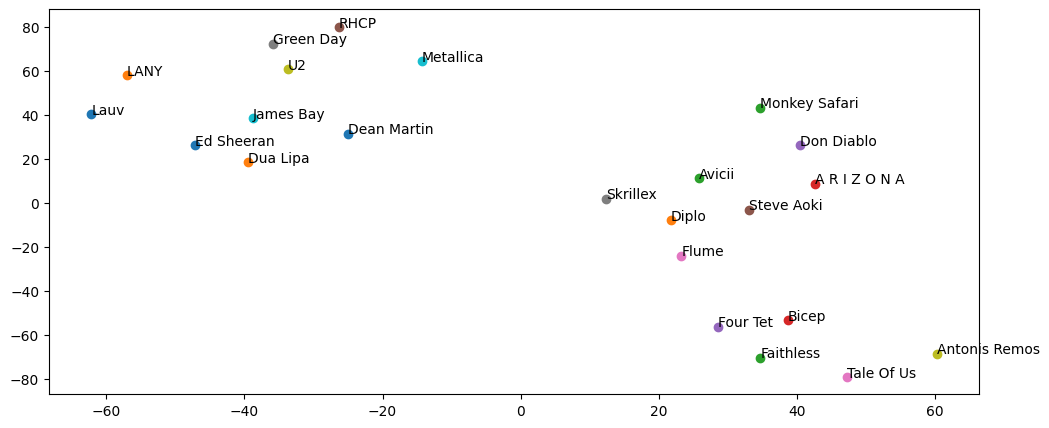

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tokens = []
labels = []

for name in interested_artists:
    labels.append(name)
    tokens.append(mdl.wv.get_vector(interested_artists[name]))

tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2000, random_state=13)
new_values = tsne_model.fit_transform(np.array(tokens))

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
fig, ax = plt.subplots(figsize=(12,5)) 
for i in range(len(x)):
    ax.scatter(x[i], y[i])
    
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

plt.show()

In [27]:
mdl.save("../models/artist_embedding_v4.model")